# A simple example, solved three ways

1. CVXPY + MOSEK
2. SD ADMM
3. Coordinate descent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex, Boolean
from osd.signal_decomp_bcd import run_bcd
from osd.utilities import progress
from osd.signal_decomp_admm import calc_obj

In [4]:
TOL = 5e-6

## Data generation

In [5]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

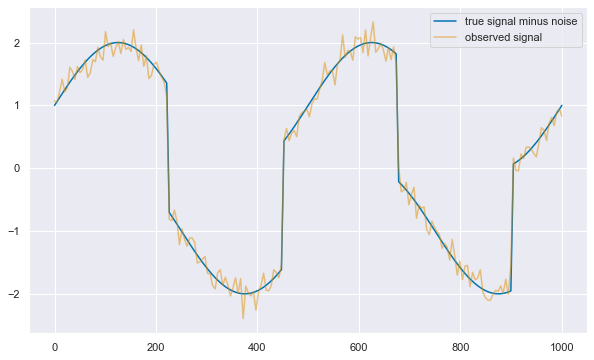

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# CVXPY + MOSEK

In [19]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = Boolean(scale=2, shift=-1)
components = [c1, c2, c3]
problem1 = Problem(y, components)

In [20]:
problem1.decompose(how='cvx')

This problem is non-convex and not solvable with CVXPY. Please try solving with ADMM.


In [21]:
opt_obj_val = problem1.objective_value
opt_obj_val

In [22]:
problem1.plot_decomposition(X_real=X_real);

No decomposition available.


# SD ADMM

In [60]:
problem2 = Problem(y, components)
problem2.decompose(how='admm', stopping_tolerance=1e-3)
problem2.objective_value

[============================================================] 100.0% ...0.06 sec


0.026123150030139583

In [61]:
problem2.decompose(X_init=problem2.estimates, how='bcd', stopping_tolerance=1e-10)
problem2.objective_value

[============================================================] 100.0% ...0.00 sec


0.02509508363937881

In [62]:
problem2.decompose(X_init=problem2.estimates, how='bcd', stopping_tolerance=1e-10)
problem2.objective_value

[============================================================] 100.0% ...0.00 sec


0.02509508363937881

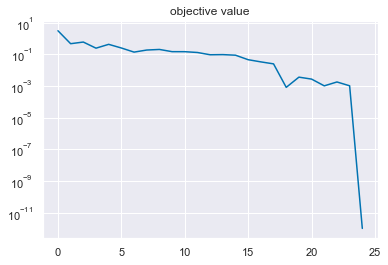

In [63]:
plt.figure()
plt.plot(np.r_[problem2.admm_result['obj_vals'], problem2.bcd_result['obj_vals']] - problem2.objective_value + 1e-12)
# plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.title('objective value')
plt.yscale('log')
plt.show()

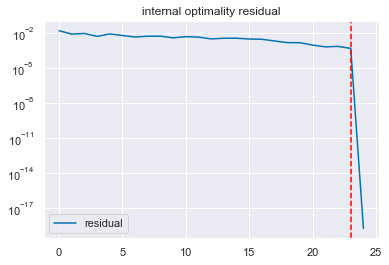

In [64]:
plt.figure()
plt.plot(np.r_[problem2.admm_result['optimality_residual'], problem2.bcd_result['optimality_residual']], label='residual')
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

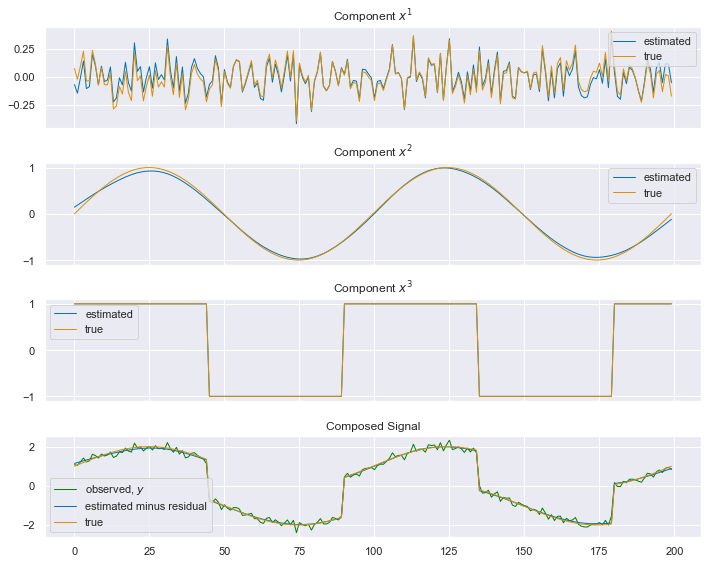

In [66]:
problem2.plot_decomposition(X_real=X_real);

# Coordinate Descent

In [28]:
problem3 = Problem(y, components)
problem3.decompose(how='bcd', stopping_tolerance=TOL)
problem3.objective_value

[============================================================] 100.0% ...0.03 sec


0.32294424637304237

In [29]:
len(problem3.bcd_result['obj_vals'])

15

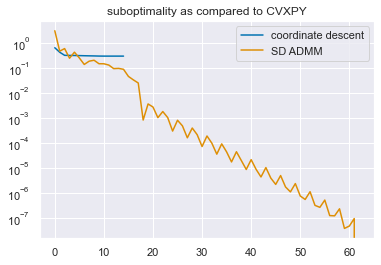

In [33]:
plt.figure()
ref = np.min(np.r_[problem3.bcd_result['obj_vals'], problem2.admm_result['obj_vals']])
plt.plot(problem3.bcd_result['obj_vals'] - ref, label='coordinate descent')
plt.plot(problem2.admm_result['obj_vals'] - ref, label='SD ADMM')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.legend()
plt.show()

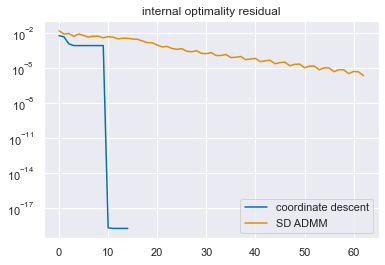

In [34]:
plt.figure()
plt.plot(problem3.bcd_result['optimality_residual'], label='coordinate descent')
plt.plot(problem2.admm_result['optimality_residual'], label='SD ADMM')
plt.yscale('log')
plt.title('internal optimality residual')
plt.legend()
plt.show()

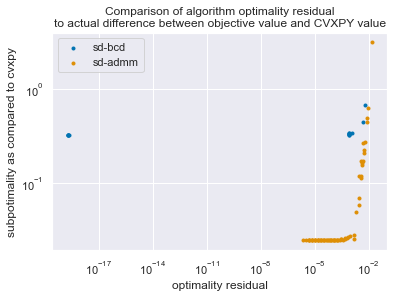

In [40]:
plt.scatter(problem3.bcd_result['optimality_residual'], problem3.bcd_result['obj_vals'], 
            label='sd-bcd', marker='.')
plt.scatter(problem2.admm_result['optimality_residual'], problem2.admm_result['obj_vals'], 
            label='sd-admm', marker='.')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(plt.ylim())
plt.xlabel('optimality residual')
plt.ylabel('subpotimality as compared to cvxpy')
# plt.gca().set_aspect('equal')
plt.legend()
plt.title('Comparison of algorithm optimality residual\nto actual difference between objective value and CVXPY value');

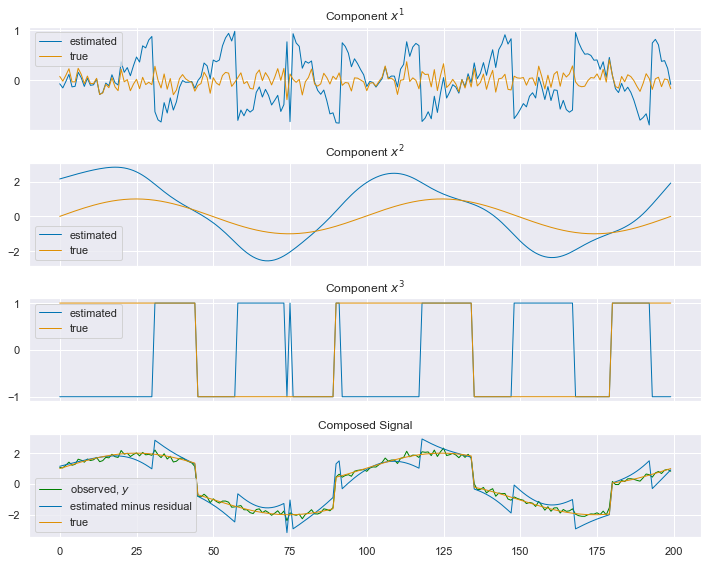

In [36]:
problem3.plot_decomposition(X_real=X_real);

### Hybrid

[============================================================] 100.0% ...0.00 sec


In [46]:
problem2.objective_value

0.02509508363937881

In [47]:
0.02509511305810197 - 0.02509508363937881

2.941872315892491e-08